***Etude Breast Cancer Wisconsin***

In [81]:
%matplotlib inline

In [82]:
import os
os.environ["OMP_NUM_THREADS"] = '1'

In [83]:
# pour eviter les messages d'erreur (en particulier de seaborn)
import warnings

In [84]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.spatial import distance

from sklearn import datasets
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [85]:
# options pour pandas
pd.set_option("display.max_columns",30)
pd.set_option('display.max_rows', 30)

In [86]:
def compute_bic(kmeans,X):
    """
    Computes the BIC metric for a given clusters

    Parameters:
    -----------------------------------------
    kmeans:  List of clustering object from scikit learn

    X     :  multidimension np array of data points

    Returns:
    -----------------------------------------
    BIC value
    """
    # assign centers and labels
    centers = [kmeans.cluster_centers_]
    labels  = kmeans.labels_
    #number of clusters
    m = kmeans.n_clusters
    # size of the clusters
    n = np.bincount(labels)
    #size of data set
    N, d = X.shape

    #compute variance for all clusters beforehand
    cl_var = (1.0 / (N - m) / d) * sum([sum(distance.cdist(X[np.where(labels == i)], [centers[0][i]], 'euclidean')**2) for i in range(m)])

    const_term = 0.5 * m * np.log(N) * (d+1)

    BIC = -( np.sum([n[i] * np.log(n[i]) 
                  - n[i] * np.log(N) 
                  - ((n[i] * d) / 2) * np.log(2*np.pi*cl_var) 
                  - ((n[i] - 1) * d/ 2) for i in range(m)]) 
           - const_term )

    return BIC


**0. Les données**

In [87]:
column_names = [
    'ID', 'Diagnosis',
    'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean',
    'compactness_mean', 'concavity_mean', 'concave_points_mean', 'symmetry_mean', 'fractal_dimension_mean',
    'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
    'compactness_se', 'concavity_se', 'concave_points_se', 'symmetry_se', 'fractal_dimension_se',
    'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst',
    'compactness_worst', 'concavity_worst', 'concave_points_worst', 'symmetry_worst', 'fractal_dimension_worst'
]

df = pd.read_csv('wdbc.data', header=None, names=column_names)


In [88]:
print(f"Forme du dataset: {df.shape}")
print(f"Premières lignes:")
print(df.head())

print(f"\nDistribution des diagnostics:")
print(df['Diagnosis'].value_counts())
missing_values = df.isnull().sum()
if missing_values.sum() == 0:
    print("Aucune valeur manquante détectée")
else:
    print(f"Valurs manquantes : {missing_values[missing_values > 0]}")

# matrice des features : colonnes 3 à 32
X = df.drop(['ID', 'Diagnosis'], axis=1).values
# encodage de la target value
y = df['Diagnosis'].map({'M': 0, 'B': 1}).values  # M=Malin=0, B=Bénin=1

print(f"\nMatrice des features X: {X.shape}")
print(f"Vecteur des labels y: {y.shape}")
print(f"Classes: M (Malin) = 0, B (Bénin) = 1")

Forme du dataset: (569, 32)
Premières lignes:
         ID Diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave_points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   symmetry_mean

In [89]:
#grouper les features 
mean_features = [col for col in column_names if 'mean' in col or ('radius' in col and 'se' not in col and 'worst' not in col)]
se_features = [col for col in column_names if 'se' in col]
worst_features = [col for col in column_names if 'worst' in col]

print(f"Features moyennes (mean): {len(mean_features)}")
print(f"Features erreur standard (se): {len(se_features)}")
print(f"Features worst (plus grandes valeurs): {len(worst_features)}")


Features moyennes (mean): 10
Features erreur standard (se): 10
Features worst (plus grandes valeurs): 10


**Matrice de corrélation**

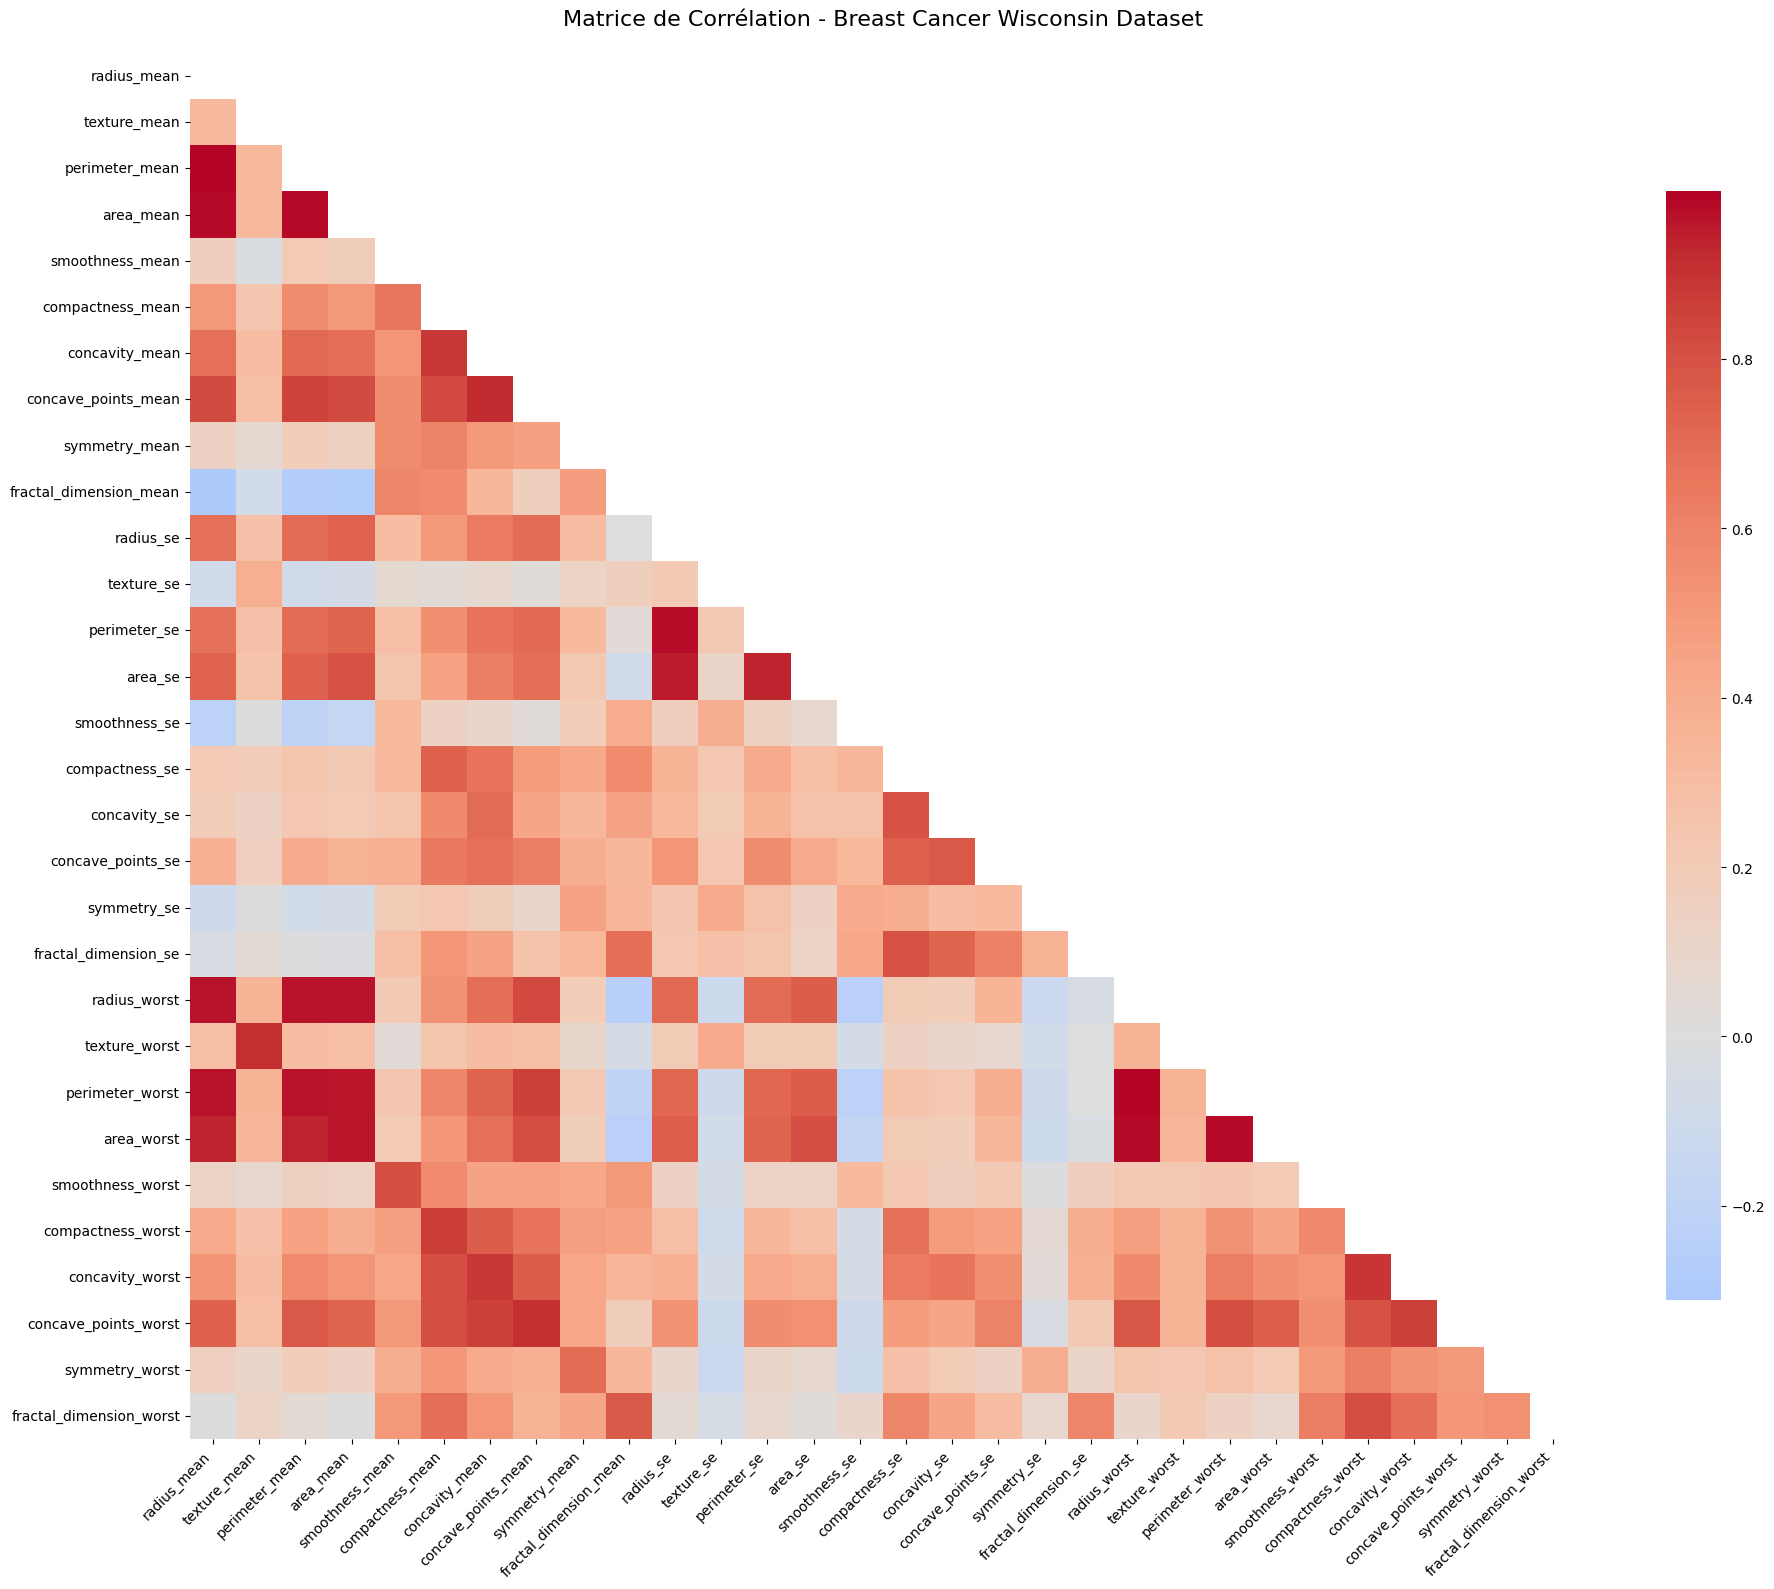

Forme de la matrice de corrélation: (30, 30)


In [90]:
# Créer la matrice de corrélation complète (sans ID)
features_df = df.drop(['ID', 'Diagnosis'], axis=1)
correlation_matrix = features_df.corr()

plt.figure(figsize=(20, 16))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, 
            mask=mask,
            annot=False, 
            cmap='coolwarm', 
            center=0,
            square=True,
            fmt='.2f',
            cbar_kws={"shrink": 0.8})
plt.title('Matrice de Corrélation - Breast Cancer Wisconsin Dataset', fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print(f"Forme de la matrice de corrélation: {correlation_matrix.shape}")

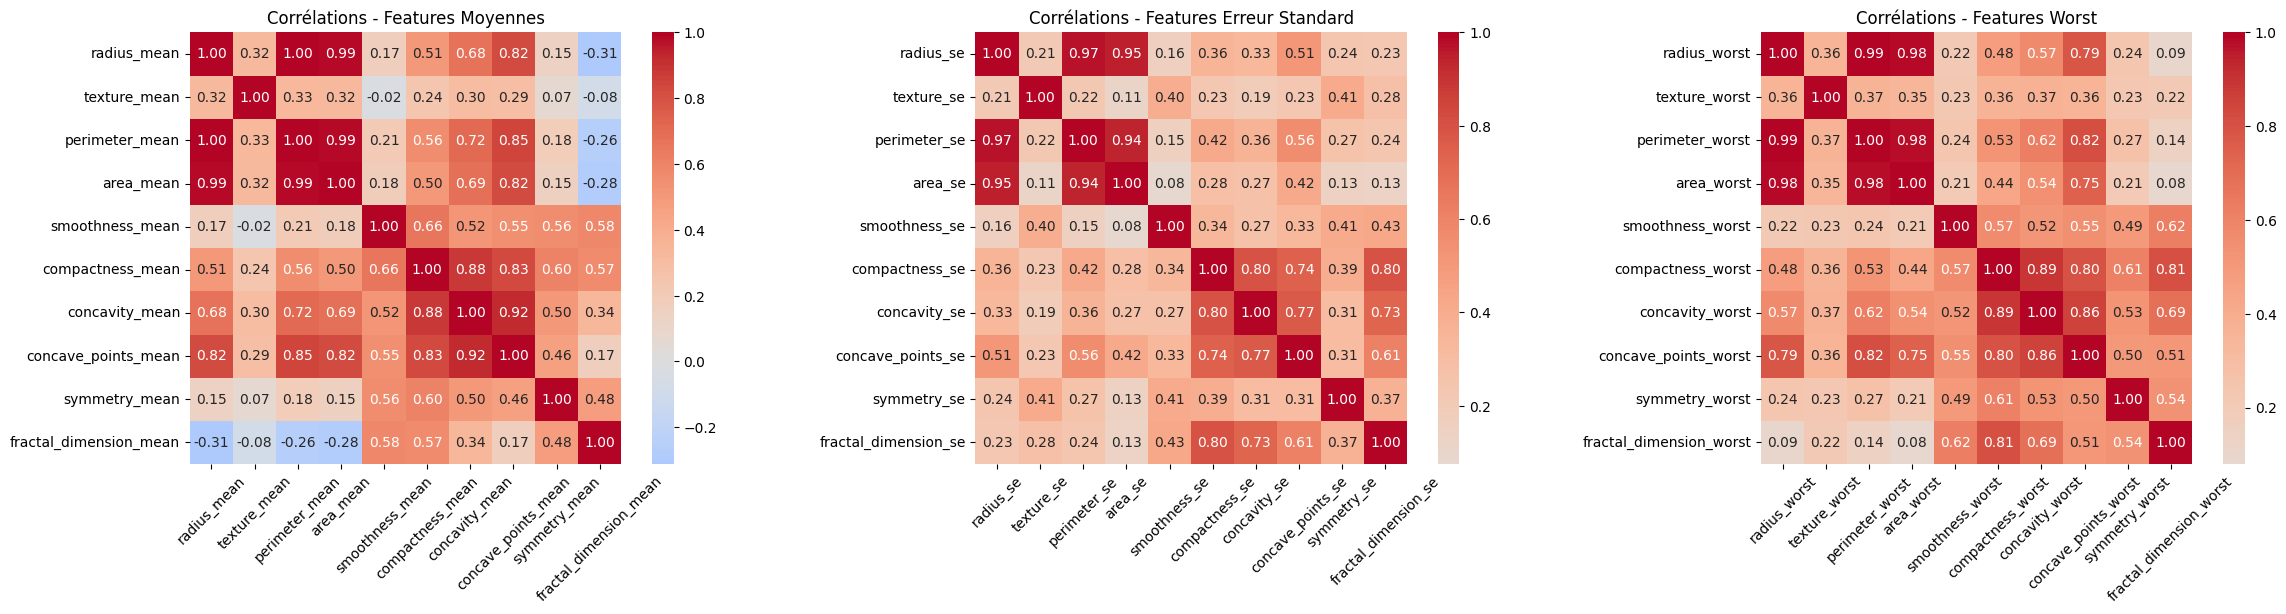

In [91]:
fig, axes = plt.subplots(1, 3, figsize=(24, 6))

# Corrélations features moyennes
corr_mean = features_df[mean_features].corr()
sns.heatmap(corr_mean, annot=True, cmap='coolwarm', center=0, 
            square=True, ax=axes[0], fmt='.2f')
axes[0].set_title('Corrélations - Features Moyennes')
axes[0].tick_params(axis='x', rotation=45)

# Corrélations features SE
corr_se = features_df[se_features].corr()
sns.heatmap(corr_se, annot=True, cmap='coolwarm', center=0, 
            square=True, ax=axes[1], fmt='.2f')
axes[1].set_title('Corrélations - Features Erreur Standard')
axes[1].tick_params(axis='x', rotation=45)

# Corrélations features worst
corr_worst = features_df[worst_features].corr()
sns.heatmap(corr_worst, annot=True, cmap='coolwarm', center=0, 
            square=True, ax=axes[2], fmt='.2f')
axes[2].set_title('Corrélations - Features Worst')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

**Statistiques descriptives :**

Corrélation moyenne: 0.370
Corrélation médiane: 0.345
Corrélation max: 0.998
Corrélation min: -0.312


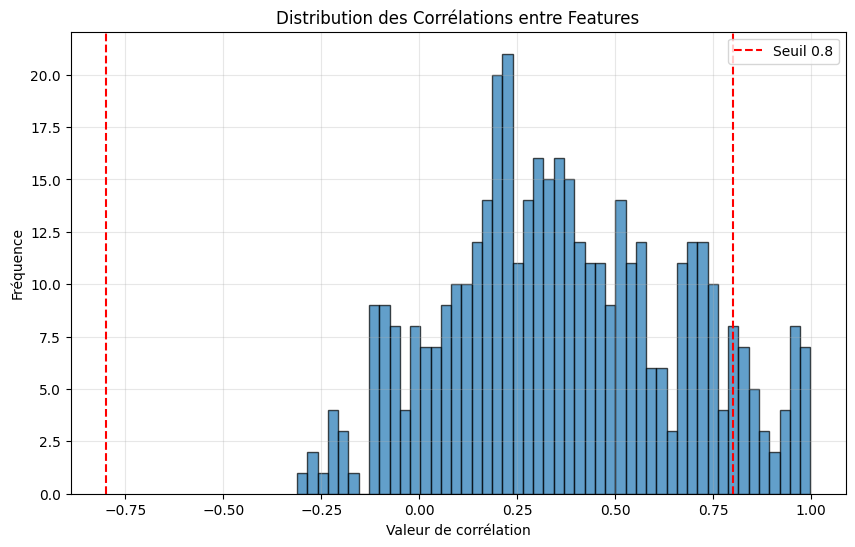

In [92]:
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
correlation_values = correlation_matrix.values[~mask]

print(f"Corrélation moyenne: {np.mean(correlation_values):.3f}")
print(f"Corrélation médiane: {np.median(correlation_values):.3f}")
print(f"Corrélation max: {np.max(correlation_values):.3f}")
print(f"Corrélation min: {np.min(correlation_values):.3f}")

plt.figure(figsize=(10, 6))
plt.hist(correlation_values, bins=50, alpha=0.7, edgecolor='black')
plt.axvline(0.8, color='red', linestyle='--', label='Seuil 0.8')
plt.axvline(-0.8, color='red', linestyle='--')
plt.xlabel('Valeur de corrélation')
plt.ylabel('Fréquence')
plt.title('Distribution des Corrélations entre Features')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [93]:
# analyse corrélations fortes
correlation_pairs = []
feature_names = features_df.columns

for i in range(len(feature_names)):
    for j in range(i+1, len(feature_names)):
        corr_value = correlation_matrix.iloc[i, j]
        if abs(corr_value) > 0.8:
            correlation_pairs.append((feature_names[i], feature_names[j], corr_value))

print(f"Nombre de paires avec corrélation > 0.8: {len(correlation_pairs)}")
print(correlation_pairs)

Nombre de paires avec corrélation > 0.8: 44
[('radius_mean', 'perimeter_mean', np.float64(0.9978552814938109)), ('radius_mean', 'area_mean', np.float64(0.9873571700566127)), ('radius_mean', 'concave_points_mean', np.float64(0.8225285223871786)), ('radius_mean', 'radius_worst', np.float64(0.9695389726112055)), ('radius_mean', 'perimeter_worst', np.float64(0.9651365139559871)), ('radius_mean', 'area_worst', np.float64(0.9410824595860461)), ('texture_mean', 'texture_worst', np.float64(0.912044588840421)), ('perimeter_mean', 'area_mean', np.float64(0.9865068039913907)), ('perimeter_mean', 'concave_points_mean', np.float64(0.8509770412528191)), ('perimeter_mean', 'radius_worst', np.float64(0.9694763634663146)), ('perimeter_mean', 'perimeter_worst', np.float64(0.9703868870426394)), ('perimeter_mean', 'area_worst', np.float64(0.9415498080023068)), ('area_mean', 'concave_points_mean', np.float64(0.8232688686524342)), ('area_mean', 'area_se', np.float64(0.8000859212343201)), ('area_mean', 'radi

**ACP**

   PCA 90.0% variance: 7 composantes (0.910 variance)
PC1: concave_points_mean
PC2: fractal_dimension_mean
PC3: texture_se
PC4: texture_worst
PC5: smoothness_mean
PC6: symmetry_worst
PC7: fractal_dimension_worst
   PCA 95.0% variance: 10 composantes (0.952 variance)
PC1: concave_points_mean
PC2: fractal_dimension_mean
PC3: texture_se
PC4: texture_worst
PC5: smoothness_mean
PC6: symmetry_worst
PC7: fractal_dimension_worst
PC8: smoothness_se
PC9: concavity_se
PC10: symmetry_mean
   PCA 99.0% variance: 17 composantes (0.991 variance)
PC1: concave_points_mean
PC2: fractal_dimension_mean
PC3: texture_se
PC4: texture_worst
PC5: smoothness_mean
PC6: symmetry_worst
PC7: fractal_dimension_worst
PC8: smoothness_se
PC9: concavity_se
PC10: symmetry_mean
PC11: concavity_se
PC12: compactness_worst
PC13: concave_points_se
PC14: compactness_se
PC15: fractal_dimension_mean
PC16: fractal_dimension_worst
PC17: symmetry_worst


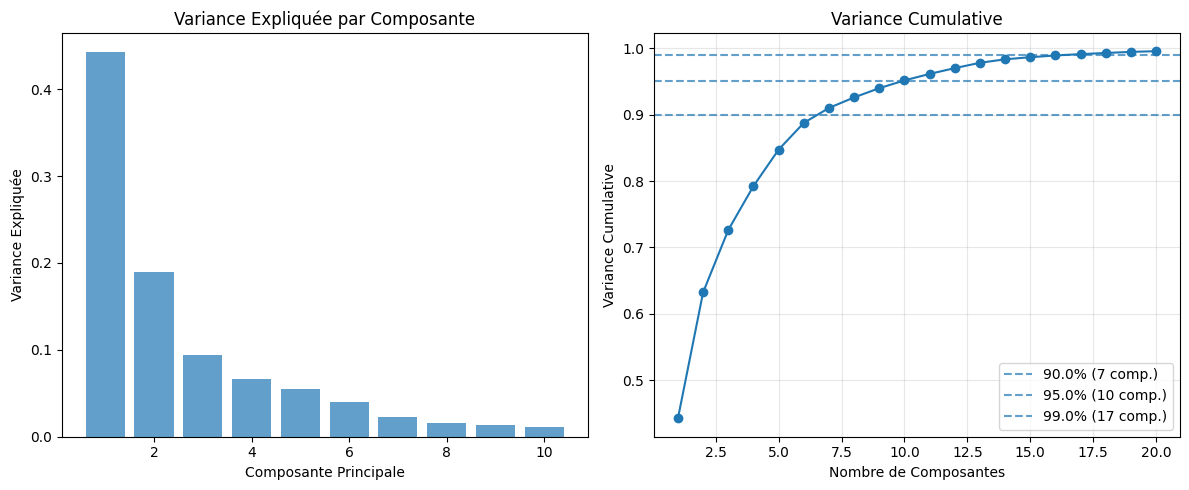

In [94]:
variance_thresholds = [0.90, 0.95, 0.99]
pca_results = {}

# standardisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

for threshold in variance_thresholds:
    pca = PCA(n_components=threshold)
    X_pca = pca.fit_transform(X_scaled)
    n_components = pca.n_components_
    explained_var = pca.explained_variance_ratio_.sum()
    
    pca_results[threshold] = {
        'data': X_pca,
        'n_components': n_components,
        'explained_variance': explained_var,
        'pca_object': pca
    }
    
    print(f"   PCA {threshold*100}% variance: {n_components} composantes ({explained_var:.3f} variance)")
    for i in range(pca.n_components_):
        max_idx = np.argmax(np.abs(pca.components_[i]))
        print(f"PC{i+1}: {features_df.columns[max_idx]}")

# Visualisation de l'impact de l'ACP
pca_full = PCA()
X_pca_full = pca_full.fit_transform(X_scaled)
variance_explained = pca_full.explained_variance_ratio_
cumulative_variance = np.cumsum(variance_explained)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.bar(range(1, 11), variance_explained[:10], alpha=0.7)
plt.title('Variance Expliquée par Composante')
plt.xlabel('Composante Principale')
plt.ylabel('Variance Expliquée')

plt.subplot(1, 2, 2)
plt.plot(range(1, 21), cumulative_variance[:20], 'o-')
for threshold in variance_thresholds:
    idx = np.argmax(cumulative_variance >= threshold)
    plt.axhline(y=threshold, linestyle='--', alpha=0.7, 
                label=f'{threshold*100}% ({idx+1} comp.)')
plt.title('Variance Cumulative')
plt.xlabel('Nombre de Composantes')
plt.ylabel('Variance Cumulative')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

['concave_points_mean', 'fractal_dimension_mean', 'texture_se', 'texture_worst', 'smoothness_mean', 'symmetry_worst', 'fractal_dimension_worst', 'smoothness_se', 'concavity_se', 'symmetry_mean']


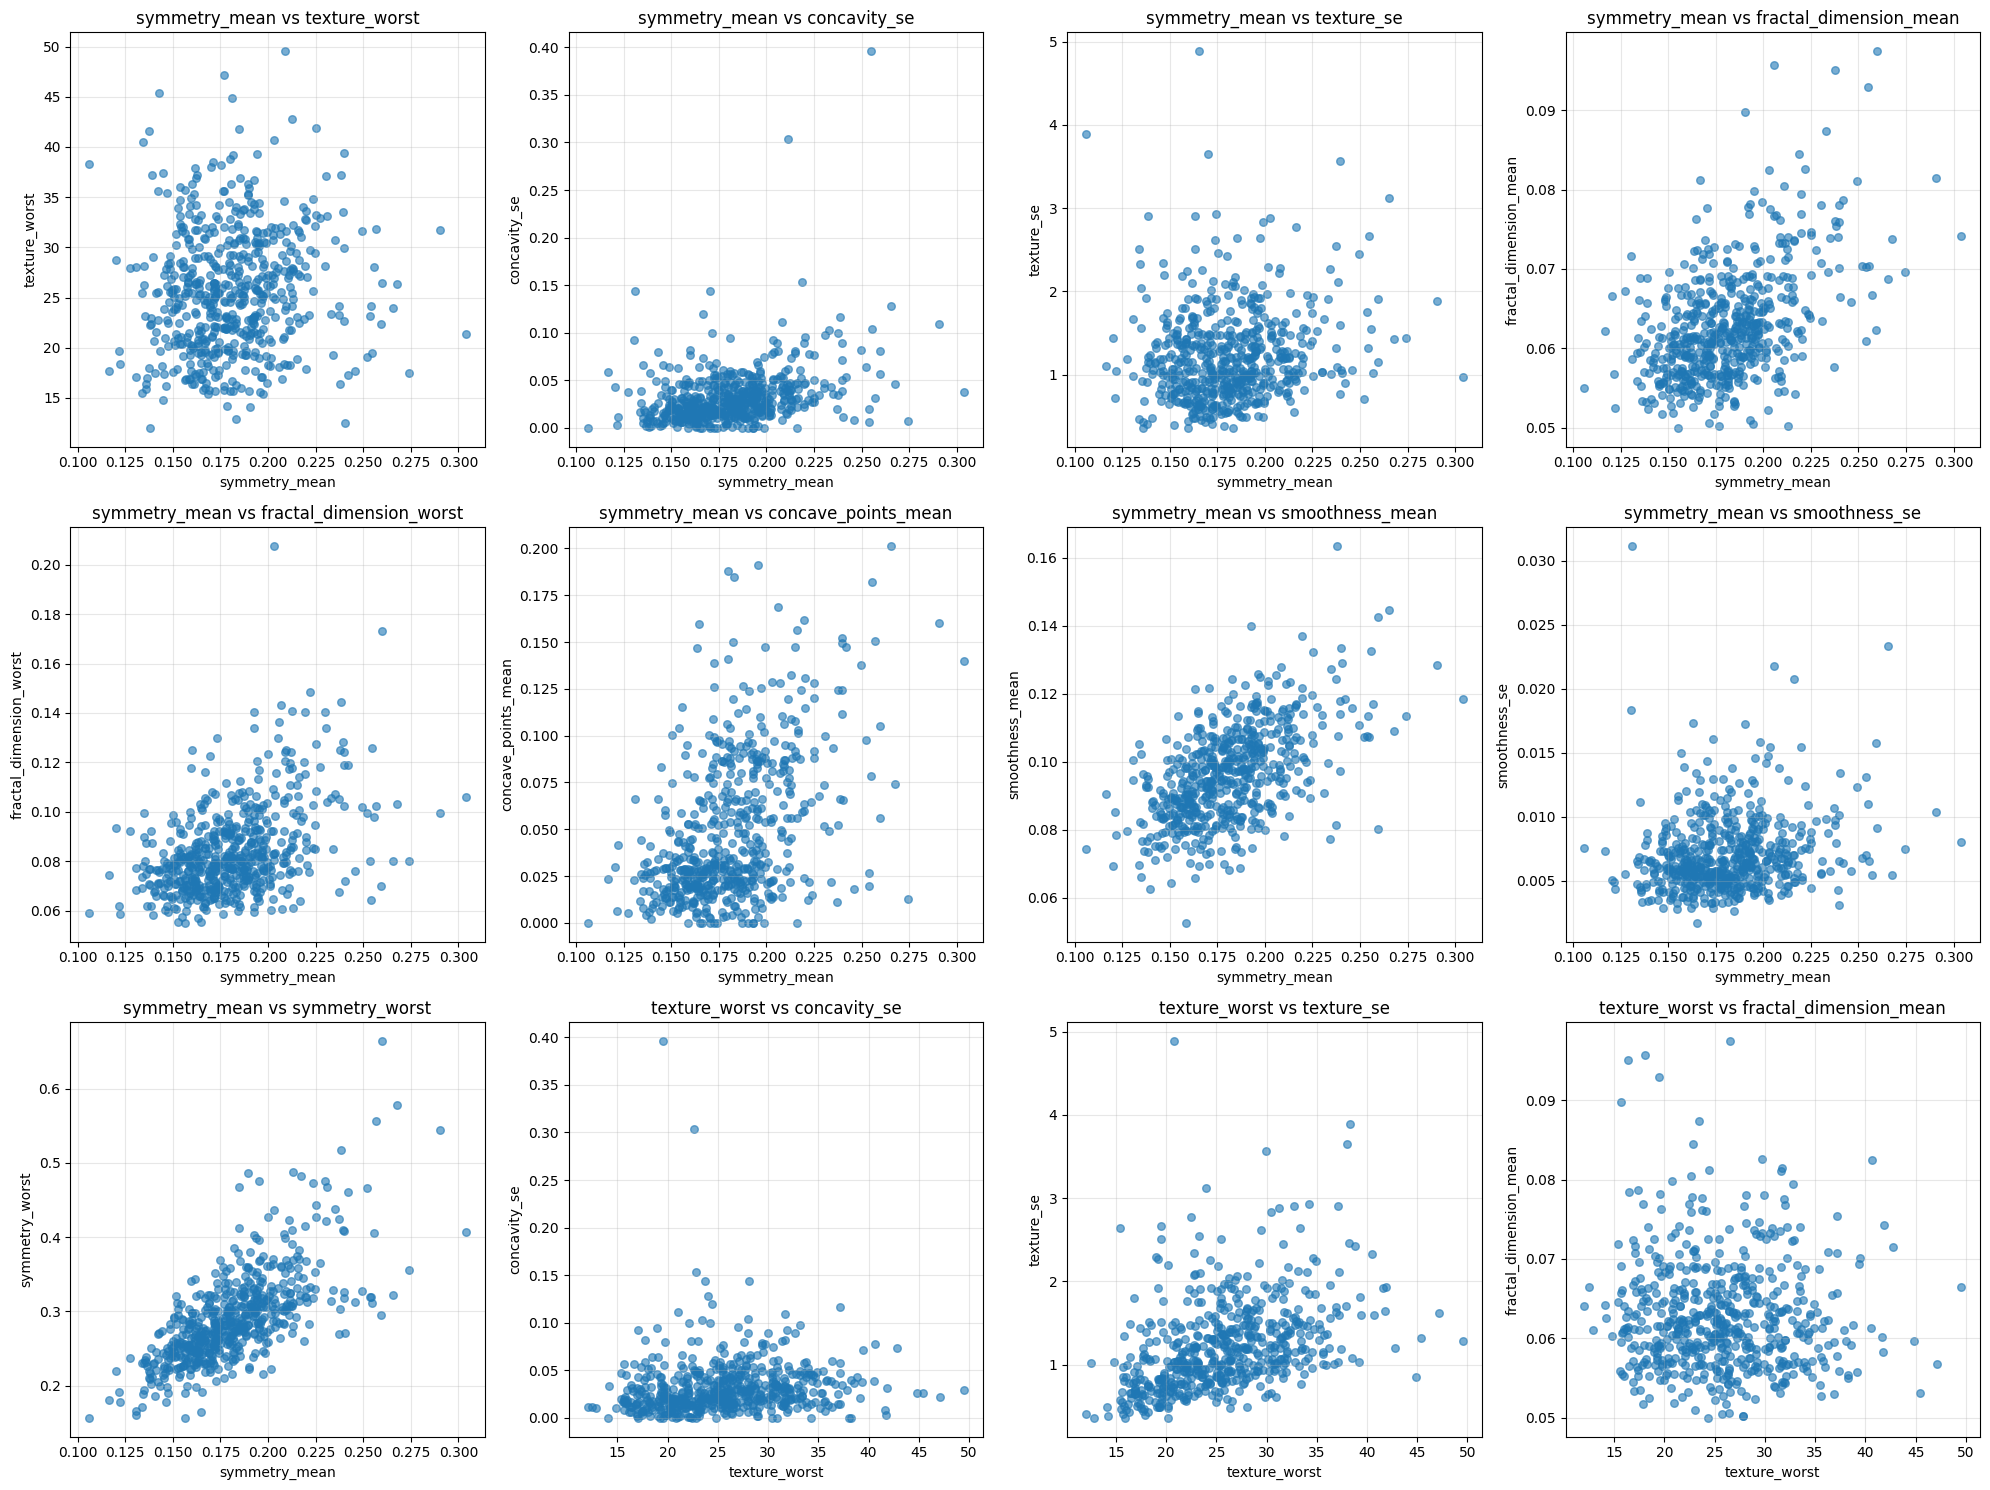

In [95]:
# scatter plot
key_features_pca = []
for i in range(10):  # 10 features top ACP >  95% variance
    max_idx = np.argmax(np.abs(pca.components_[i]))
    key_features_pca.append(features_df.columns[max_idx])
print(key_features_pca)

key_features_pca = list(set(key_features_pca))
scatter_pairs = [(key_features_pca[i], key_features_pca[j]) 
                for i in range(len(key_features_pca)) 
                for j in range(i+1, len(key_features_pca))][:12] 

fig, axes = plt.subplots(3, 4, figsize=(20, 15))
axes = axes.ravel()

for i, (feat1, feat2) in enumerate(scatter_pairs):
    axes[i].scatter(features_df[feat1], features_df[feat2], alpha=0.6, s=30)
    axes[i].set_xlabel(feat1)
    axes[i].set_ylabel(feat2)
    axes[i].set_title(f'{feat1} vs {feat2}')
    axes[i].grid(True, alpha=0.3)

for j in range(len(scatter_pairs), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

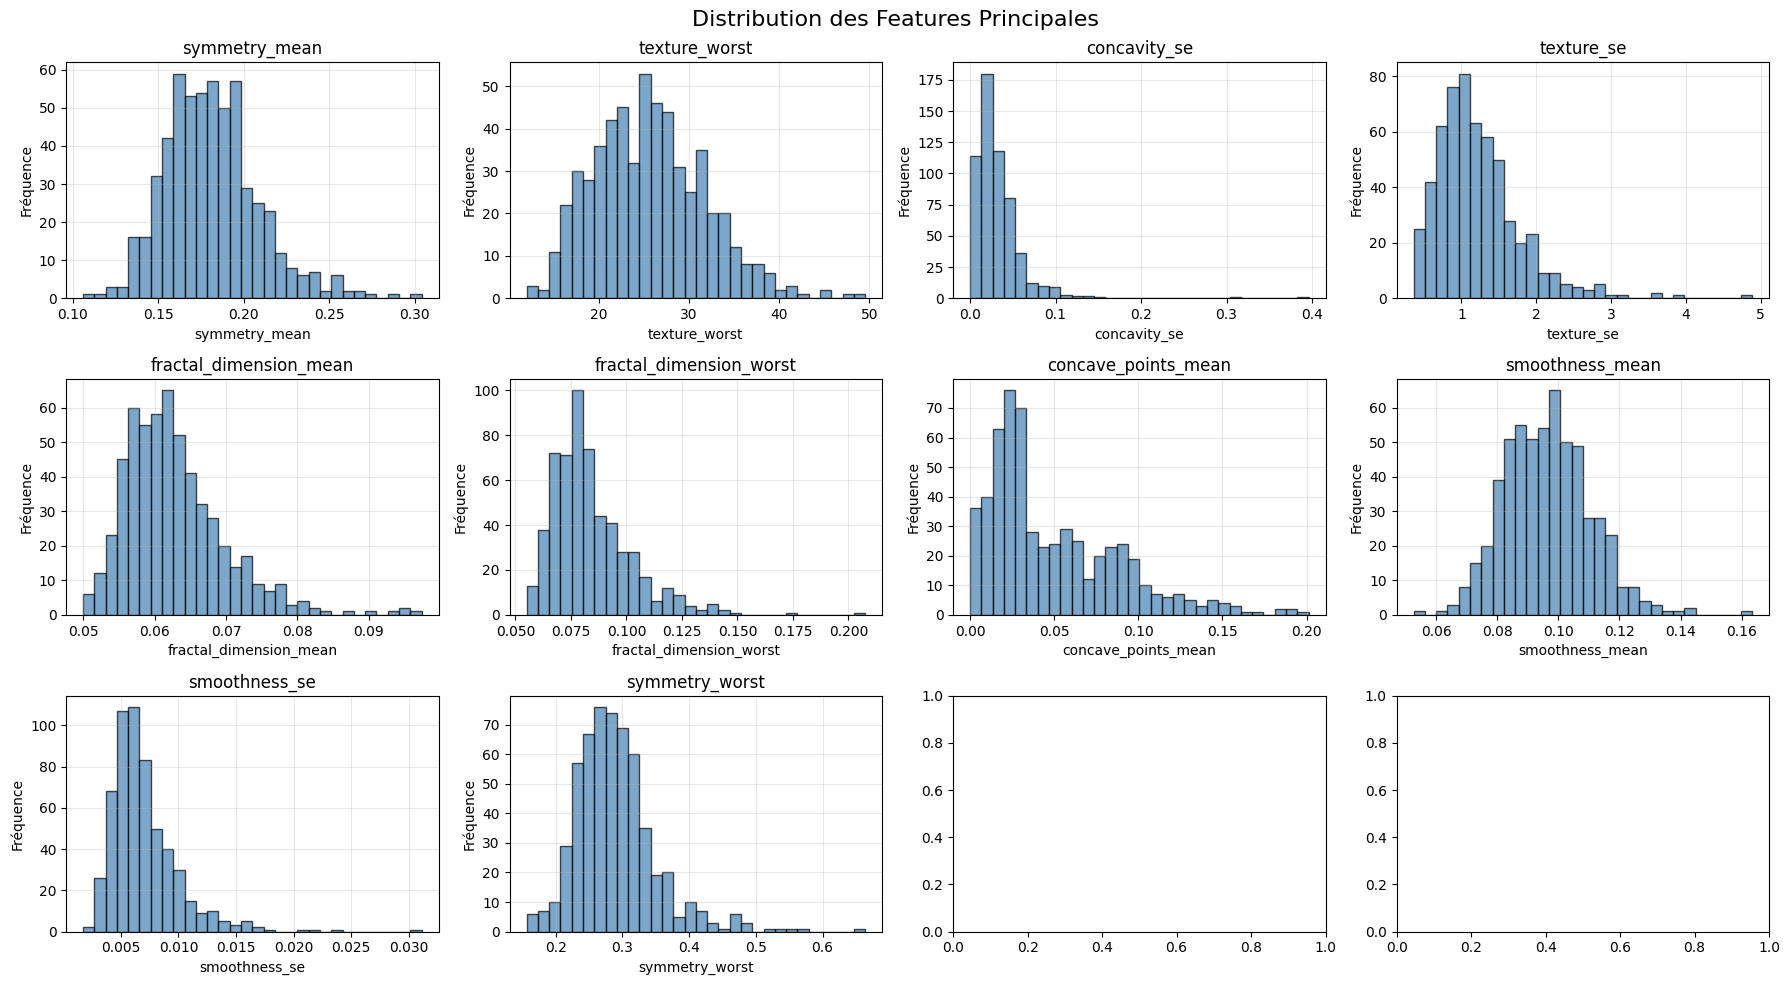

In [96]:
# histogrammes
fig, axes = plt.subplots(3, 4, figsize=(18, 10))
axes = axes.ravel()

for i, feature in enumerate(key_features_pca):
    axes[i].hist(features_df[feature], bins=30, alpha=0.7, edgecolor='black', color='steelblue')
    axes[i].set_title(feature)
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Fréquence')
    axes[i].grid(True, alpha=0.3)

plt.suptitle('Distribution des Features Principales', fontsize=16)
plt.tight_layout()
plt.show()


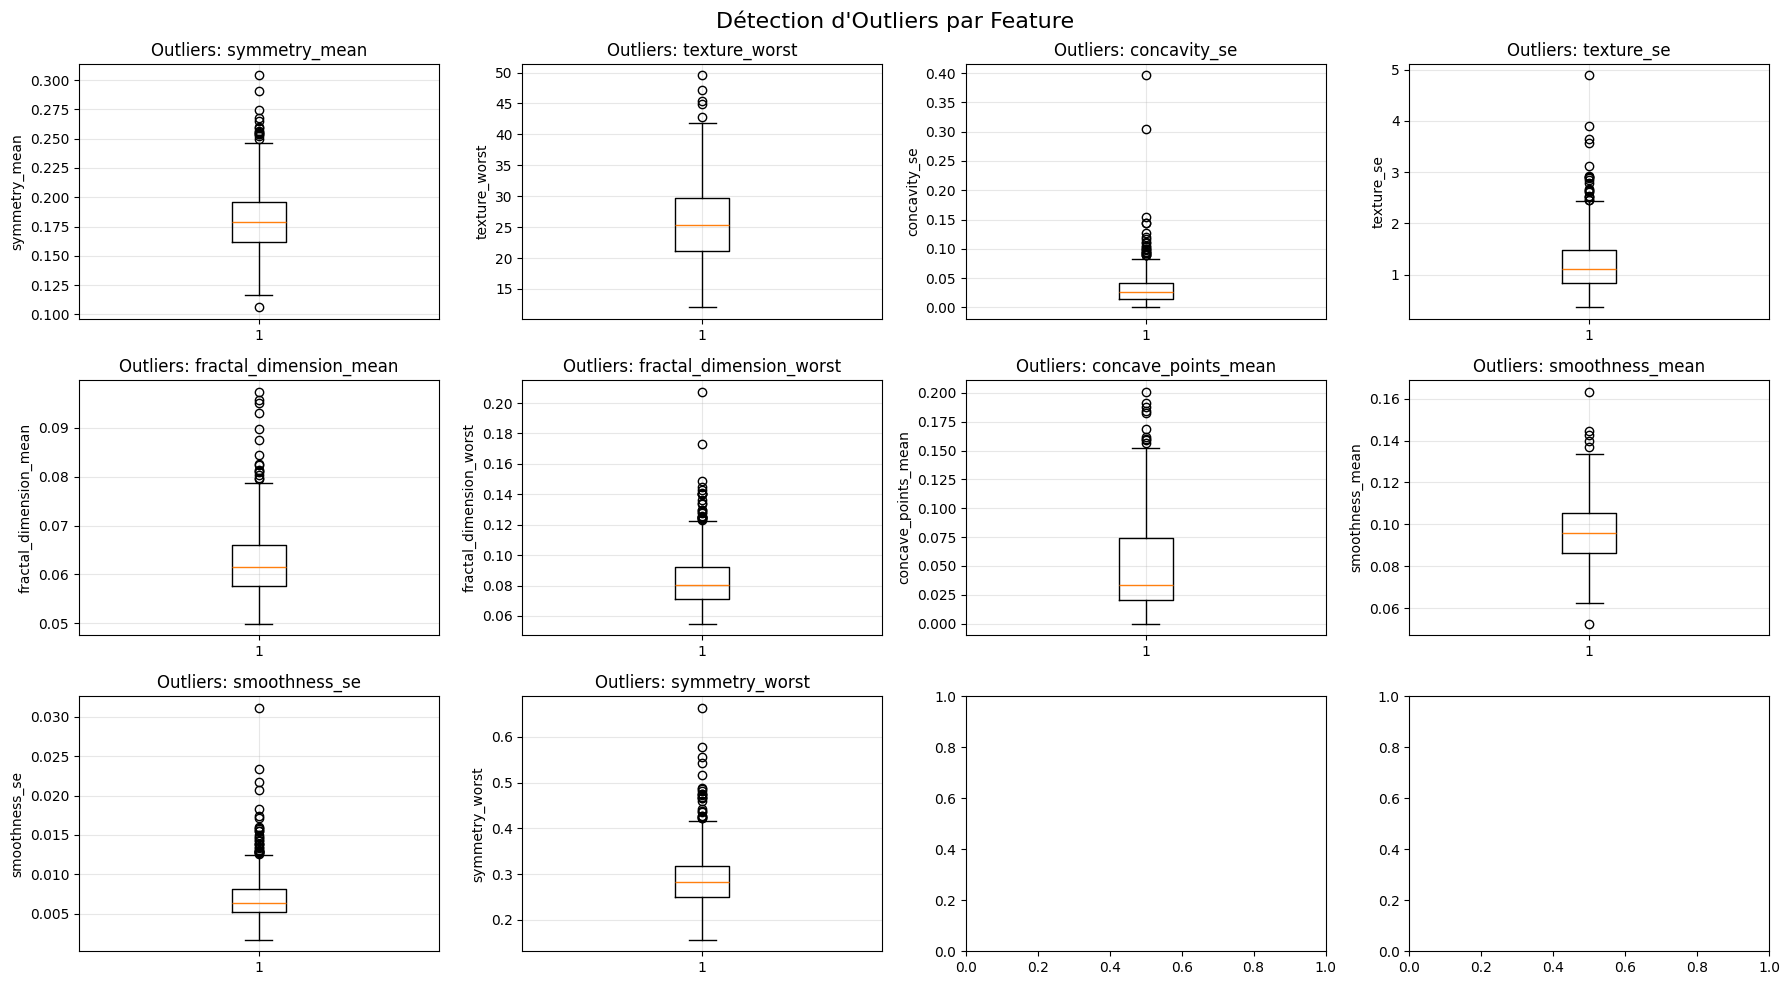

In [97]:
# outliers
fig, axes = plt.subplots(3, 4, figsize=(18, 10))
axes = axes.ravel()

for i, feature in enumerate(key_features_pca):
    axes[i].boxplot(features_df[feature])
    axes[i].set_title(f'Outliers: {feature}')
    axes[i].set_ylabel(feature)
    axes[i].grid(True, alpha=0.3)

plt.suptitle('Détection d\'Outliers par Feature', fontsize=16)
plt.tight_layout()
plt.show()

**Standardisation**

Données standardisées: (569, 30)
Moyenne après standardisation: [-1.37363271e-16  6.86816353e-17 -1.24875700e-16 -2.18532476e-16
 -8.36667193e-16]...
Écart-type après standardisation: [1. 1. 1. 1. 1.]...


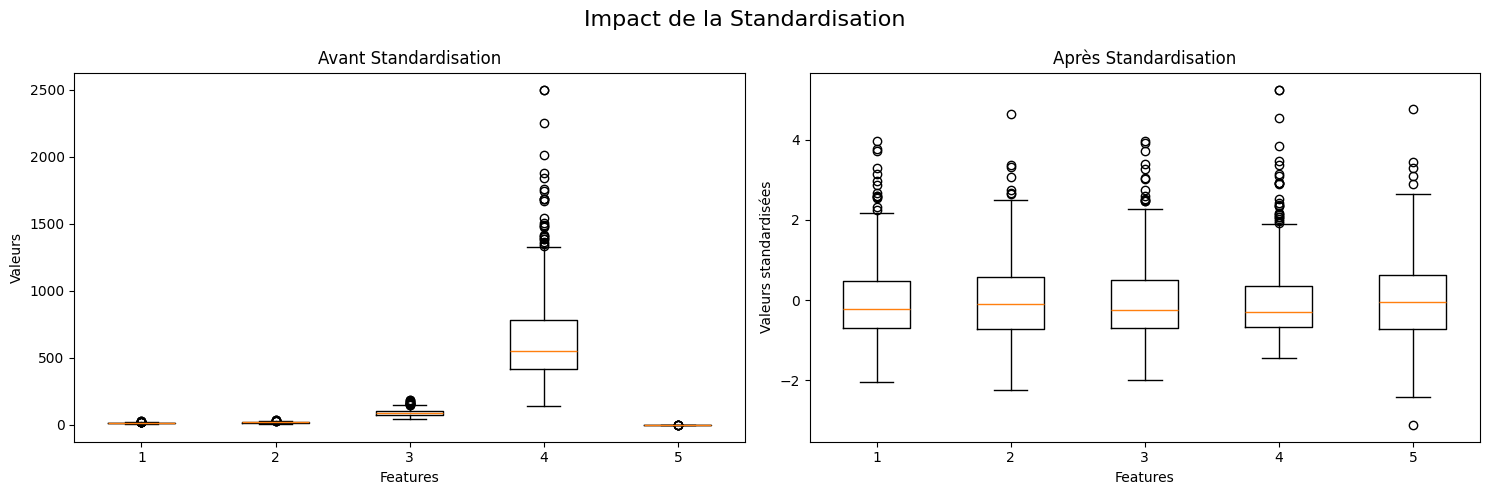

In [98]:
print(f"Données standardisées: {X_scaled.shape}")
print(f"Moyenne après standardisation: {np.mean(X_scaled, axis=0)[:5]}...")
print(f"Écart-type après standardisation: {np.std(X_scaled, axis=0)[:5]}...")

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].boxplot(X[:, :5])  # 5 premières features
axes[0].set_title('Avant Standardisation')
axes[0].set_xlabel('Features')
axes[0].set_ylabel('Valeurs')

axes[1].boxplot(X_scaled[:, :5])  # 5 premières features
axes[1].set_title('Après Standardisation')
axes[1].set_xlabel('Features')
axes[1].set_ylabel('Valeurs standardisées')

plt.suptitle('Impact de la Standardisation', fontsize=16)
plt.tight_layout()
plt.show()

**K-means : total et sur features réduites par ACP**

In [ ]:
# K-means simple 
X_key = features_df[key_features_pca].values
scaler_key = StandardScaler()
X_key_scaled = scaler_key.fit_transform(X_key)

print(f"Données complètes: {X_scaled.shape}")
print(f"Key features ACP: {X_key_scaled.shape}")
print(f"Features sélectionnées: {key_features_pca}")

# Test K-means pour k=2 à k=10
k_range = range(2, 11)

# données complètes
print(f"\nk-means pour les 30 features")
for k in k_range:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    
    sil = silhouette_score(X_scaled, labels)
    ch = calinski_harabasz_score(X_scaled, labels)
    db = davies_bouldin_score(X_scaled, labels)
    
    print(f"k={k}: Silhouette={sil:.3f}, CH={ch:.1f}, DB={db:.3f}")

# key features
print(f"\nk-means sur les key features de l'ACP : ({len(key_features_pca)} features)")
for k in k_range:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = kmeans.fit_predict(X_key_scaled)
    
    sil = silhouette_score(X_key_scaled, labels)
    ch = calinski_harabasz_score(X_key_scaled, labels)
    db = davies_bouldin_score(X_key_scaled, labels)
    
    print(f"k={k}: Silhouette={sil:.3f}, CH={ch:.1f}, DB={db:.3f}")

print('fin')

Données complètes: (569, 30)
Key features ACP: (569, 10)
Features sélectionnées: ['symmetry_mean', 'texture_worst', 'concavity_se', 'texture_se', 'fractal_dimension_mean', 'fractal_dimension_worst', 'concave_points_mean', 'smoothness_mean', 'smoothness_se', 'symmetry_worst']

k-means pour les 30 features
k=2: Silhouette=0.343, CH=267.7, DB=1.321
k=3: Silhouette=0.314, CH=197.1, DB=1.529
k=4: Silhouette=0.283, CH=158.9, DB=1.489
k=5: Silhouette=0.158, CH=140.2, DB=1.756
k=6: Silhouette=0.160, CH=128.6, DB=1.720
k=7: Silhouette=0.153, CH=118.4, DB=1.677
k=8: Silhouette=0.147, CH=108.4, DB=1.618
k=9: Silhouette=0.147, CH=104.8, DB=1.485
k=10: Silhouette=0.137, CH=98.4, DB=1.607

k-means sur les key features de l'ACP : (10 features)
k=2: Silhouette=0.265, CH=178.3, DB=1.614
k=3: Silhouette=0.209, CH=133.5, DB=1.817
k=4: Silhouette=0.188, CH=117.8, DB=1.695
k=5: Silhouette=0.159, CH=109.5, DB=1.673
k=6: Silhouette=0.133, CH=100.1, DB=1.632
k=7: Silhouette=0.138, CH=95.1, DB=1.467
k=8: Silho